# xtream AI Engineer Assignment - Challenge 1

## 1. Introduction

In this notebook I will develop a model for predicting the price of diamonds, based on the provided dataset. But before digging into the model, I will perform an exploratory data analysis (EDA) to get some preliminary insights and take actions to clean the data.

## 2. EDA and data cleansing

### 2.1. Data loading and overview

For this very important, first step I will start loading the data and doing some very preliminary EDA with a few `pandas` commands.

In [1]:
import pandas as pd

# Load data
data_original = pd.read_csv('../datasets/diamonds/diamonds.csv')

In [2]:
data_original.head()

carat        cut color clarity  depth  table  price     x     y     z
0   1.10      Ideal     H     SI2   62.0   55.0   4733  6.61  6.65  4.11
1   1.29      Ideal     H     SI1   62.6   56.0   6424  6.96  6.93  4.35
2   1.20    Premium     I     SI1   61.1   58.0   5510  6.88  6.80  4.18
3   1.50      Ideal     F     SI1   60.9   56.0   8770  7.43  7.36  4.50
4   0.90  Very Good     F     VS2   61.7   57.0   4493  6.17  6.21  3.82

In [3]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    5000 non-null   float64
 1   cut      5000 non-null   object 
 2   color    5000 non-null   object 
 3   clarity  5000 non-null   object 
 4   depth    5000 non-null   float64
 5   table    5000 non-null   float64
 6   price    5000 non-null   int64  
 7   x        5000 non-null   float64
 8   y        5000 non-null   float64
 9   z        5000 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 390.8+ KB


I could continue using pandas and matplotlib (or seaborn or plotly). But, rather, I will use the library `ydata profiling` (formerly known as `pandas profiling`), which is an easy-to-use and comprehensive EDA tool. I will start with a short report.

In [4]:
from ydata_profiling import ProfileReport

ProfileReport(data_original,
              title="Diamonds EDA Short Report",
              progress_bar=False,
              samples=None,
              correlations=None,
              missing_diagrams=None,
              interactions=None,
)

It is interesting to note that not all features are normally distributed. Even more, the distribution of *z* (also *x* and *y*) appear to be bimodal. I don't know the reason and don't expect this to negatively affect the model, provided it does not rely in the normality of the data.

### 2.2. Data encoding and cleansing

There are three categorical features (*cut*, *color*, and *clarity*). To my understanding, the three of them are ordered and thus I will use an ordinal encoder to convert them to numerical features.

In [5]:
from sklearn.preprocessing import OrdinalEncoder

data_encoded = data_original.copy()

CATEGORICAL_FEATS = ['cut', 'color', 'clarity']
# Categories are sorted in ascending order
# For general diamond classification, color is in the range D-Z. But, actually
# the specimens in this dataset have color in the range D-J (7 different values)
CATEGORIES_CUT = ['Fair','Good','Very Good','Ideal','Premium']
CATEGORIES_COLOR = list(map(chr, range(ord('D'), ord('J')+1)))[::-1]
CATEGORIES_CLARITY = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']
CATEGORIES = [CATEGORIES_CUT, CATEGORIES_COLOR, CATEGORIES_CLARITY]

for i, feat in enumerate(CATEGORICAL_FEATS):
    encoder = OrdinalEncoder(categories=[CATEGORIES[i]], dtype=int)
    x = data_original[feat].values.reshape(-1, 1)
    data_encoded[feat] = encoder.fit_transform(x)

There is one pair of duplicate rows in the dataset (see 'Duplicate rows' in the report above). I believe this could be related to the large number of diamonds in the dataset and the precision in the measurements of each diamond feature (for example, it could be possible that two diamonds are almost identical in every feature except the *carat*, but the difference is below the measurement precision or the real values were rounded before including them in the dataset). Therefore, I think they could genuinely be two different specimens and I will keep the two rows.

There are no missing values for any of the features or the target, but there are ten dataset observations with *price* = -1 (see the summary for *price* in the report). I could try to do some imputation for those values, but since the price is what I want to predict and these entries represent only 0,2% of the data, I will drop them.

In [6]:
data_original[data_original['price']==-1]

carat        cut color clarity  depth  table  price     x     y     z
331    1.00       Good     F     SI1   64.1   60.0     -1  6.25  6.19  3.99
2121   0.34      Ideal     E     VS2   59.8   56.0     -1  4.55  4.54  2.72
2484   1.75      Ideal     J     SI1   63.3   59.0     -1  7.63  7.57  4.81
2933   1.51      Ideal     H     VS2   62.5   55.0     -1  7.29  7.34  4.57
3155   0.31      Ideal     G     VS2   61.7   57.0     -1  4.33  4.36  2.68
3317   1.02    Premium     D     VS2   59.8   61.0     -1  6.61  6.54  3.93
3445   0.30    Premium     H     SI1   59.3   59.0     -1  4.38  4.36  2.59
3904   0.90  Very Good     G     SI2   64.2   56.0     -1  6.04  6.11  3.90
3980   0.41  Very Good     H     VS2   63.4   58.0     -1  4.77  4.66  2.99
4188   0.79      Ideal     H    VVS1   62.0   56.0     -1  5.92  5.96  3.68

In [7]:
data_clean = data_encoded.copy()
data_clean = data_clean[data_clean['price']>0]

The features *x*, *y*, and *z* have one zero value, each. Actually, this is explained by just one observation in the dataset (see next cell). These three features seem to have influence in the price (see 'Interactions' in the report). They show some correlation with each other but they are not correlated with other features (see 'Correlations' in the report). I think an imputation here would not be useful and given it is only one observation, I will drop it.

In [8]:
data_original[data_original['z']==0]

carat      cut color clarity  depth  table  price    x    y    z
4321   2.25  Premium     H     SI2   62.8   59.0  18034  0.0  0.0  0.0

In [9]:
data_clean = data_clean[data_clean['z']!=0]

### 2.3. Correlations and interactions

Now I will produce an extended report with `ydata profiling` for analyzing the correlations and interactions between features.

In [10]:
# The package ydata profiling presents the interactions as either scatter plots
# or hexbin plots. I find the scatter plots more informative. But, due to the
# underlying plot tool being used, the report becomes too heavy when scatter
# plots of more than 1000 points are generated. The package has a threshold
# setting for the number of points above which these plots are presented as
# hexbin instead of scatter. Here I left this threshold (scatter_threshold) in
# its default value in order to make the notebook light. Setting it to a number
# above 5000 will show scatter interaction plots.

# Generate the report
eda_report = ProfileReport(
    data_clean,
    title='Diamonds EDA Extended Report',
    progress_bar=False,
    samples=None,
    missing_diagrams=None,
    # Distinct values to consider a feature as categorical (default=5)
    vars={'num': {'low_categorical_threshold': 4}},
    # Number of points to plot interactions as hexbin instead of scatter (default=1000)
    plot={'scatter_threshold': 1000},
)

# Display the report
eda_report.to_notebook_iframe()

# Bug: Report not displayed when notebook viewed in github
# Workaround: save the report to a HTML file
eda_report.to_file('../reports/challenge1_eda_report.html')

Since the interaction plots are not very conclusive for the categorical features, I'd like to see boxplots of the *price* for the different values of the those features.

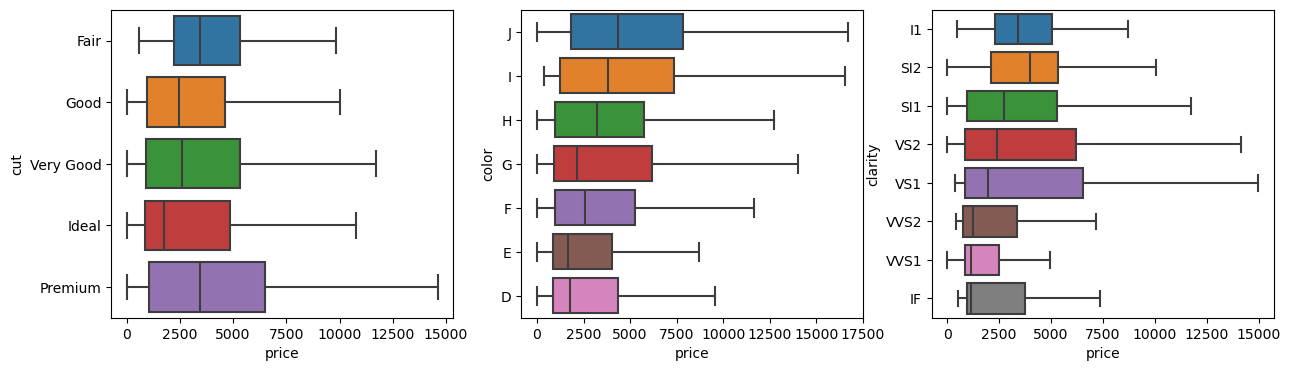

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(15,4))
# Use the option showfliers=False to remove the data points outside the whiskers
# to make the plots cleaner (just want to see if there is some variation of
# price with each of the categorical features)
for i, feat in enumerate(CATEGORICAL_FEATS):
    sns.boxplot(data=data_original, x='price', y=feat, order=CATEGORIES[i],
                showfliers=False, ax=axes[i])

Some remarks about the correlations and interactions:

- The strongest correlations are between pairs of dimensions *x*, *y*, *z* and between each of them with *carat*. The correlations between pairs of *x*, *y*, *z* translate to interactions that appear to be linear. This is not exactly the same for the interactions between *carat* with one of the former variables, in which cases the interactions tend to flatten out at the higher values of those features.

- The *price* is highly correlated with *carat* and with *x*, *y*, *z*. The interaction of *price* with each of those features doesn't look linear, but rather exponential.

- It is worth noting that *depth* and *table*, despite depending mathematically from *z* and *x*, respectively, don't show any significative correlation with other features nor the *price*. I will keep those two features in the data because they may add some detail to the model.

- The *price* seems to not be correlated with any of the three categorical features (*cut*, *color*, and *clarity*). The boxplots don't show any significative variation of the *price* with any of these features. Anyway, for the moment, I will keep them in the dataset hoping they provide some refinement to the model predictions.

- Given the remarks about correlations and interactions, to avoid redundancies, I will drop the features *x* and *y* (which are strongly correlated and have a linear interaction). Note: instead of just dropping features I could do some "feature engineering" (for example, through principal component analysis), but my idea is to try and get an interpretable model that gives feature importances, so I prefer to keep the original variables, which they have a clear meaning.

In [12]:
data_clean = data_clean.drop(columns=['x','y'])

### 2.4. Outliers

As a last step in the EDA, I will perform a quick search for outliers (or anomalies). There are several possibilities for doing this. Here I choose a multivariate method based on a robust Mahalanobis distance estimator, implemented in the following function:

In [13]:
# Source: https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33

import numpy as np
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

def robust_mahalanobis_method(data):
    # Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(data.values.T)
    X = rng.multivariate_normal(mean=np.mean(data, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ # Robust covariance
    robust_mean = cov.location_ # Robust mean
    inv_covmat = sp.linalg.inv(mcd) # Inverse covariance
    
    # Robust Mahalanobis distance
    x_minus_mu = data - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())

    # Chi2-based cutoff values for outlier identification
    # Degrees of freedom (df) = number of variables
    # Significance level = 0.1%
    C = np.sqrt(chi2.ppf((1-0.001), df=data.shape[1]))

    # Identify outliers
    outlier = []
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    
    return outlier, md

In [14]:
# Outlier indices
outliers, _ = robust_mahalanobis_method(data_encoded)
# Transform list of outlier indices to flags for all data points
outlier_flags = [i in outliers for i in data_encoded.index]
# Print summary
print(f"There are {len(outliers)} "
      f"({len(outliers)/data_clean.shape[0]*100:.1f}%) "
      f"possible outliers.")

There are 128 (2.6%) possible outliers.


Let's take a look to the identified outliers in 2D plots of *price* vs *carat* and *price* vs *z*.

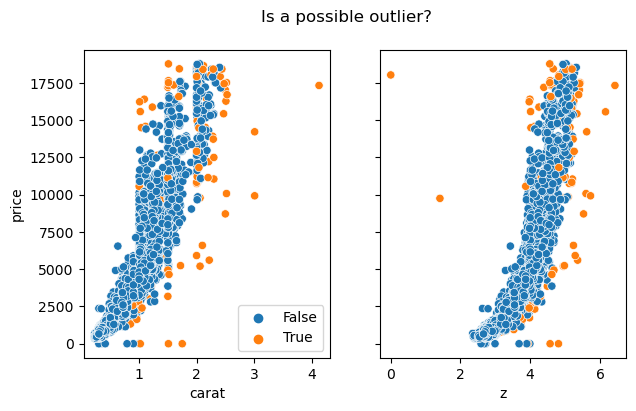

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(7,4), sharey=True)
fig.suptitle('Is a possible outlier?')
sns.scatterplot(data=data_encoded, x='carat', y='price', hue=outlier_flags,
                ax=axes[0])
sns.scatterplot(data=data_encoded, x='z', y='price', hue=outlier_flags,
                ax=axes[1], legend=None);

Handling the outliers is a tricky business, since it is plausible that the flagged observations correspond to real specimens and not some sort of data collection/processing anomaly. Although it would be easy to drop them*, I decided to keep them in the dataset. I believe they can be considered a genuine part of the population of interest. And, due to their quantity and quality, they may not have a significant influence in the model. This actually can be tested once the model is available, rendering the so-called *influential observations*. Another possibility would be to compare the model with and without the outliers or even modelling them separately. Anyway, for the sake of time, I will not further dig in the outlier subject for this challenge.

*In the next section, I will include the possibility of removing the outliers in a `imbalanced-learn` pipeline using the class `FunctionSampler` from the same package and a custom function that properly removes the outliers.

## 3. Model development

### 3.1. Model selection

From the vast amount of algorithms for tabular data regression, I would like one with good performance (time and score) that also offers interpretability and the possibility of feature selection. Also, I'm looking for an algorithm that can handle non-linear models without explicitly assuming features' nonlinearities, types of interactions between features or an underlying generation process. I think that a tree-based algorithm fulfills all these requirements.  
But even within the tree-based world the options are large. So, as a first step I will naively compare (i.e. using all the default parameters) three tree-based algorithms: an ordinary decision tree, a random forest, and a gradient boosted ensemble. For all of them, I will use their implementations in `scikit-learn`. Particularly, for the gradient boosted ensemble I will just use the `GradientBoostingRegressor` class (given the size of the dataset, both in observations and features, I think there's no need to go for more sophisticated options like histogram gradient boosting, in any of its many implementations).  
But, first things first, in case the user wants to run only this section of the notebook, I place here a the code cells for data loading, encoding and cleansing. The last two tasks are similar to the ones decided during the EDA in the previous section, but this time they will be applied in a pipeline.

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
data = pd.read_csv('../datasets/diamonds/diamonds.csv')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['price']), data['price'], test_size=0.3, random_state=41)

In [17]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

# List features and categories
NUMERIC_FEATS = ['carat', 'depth', 'table', 'x', 'y', 'z']
CATEGORICAL_FEATS = ['cut', 'color', 'clarity']
CATEGORIES_CUT = ['Fair', 'Good', 'Very Good', 'Ideal', 'Premium']
CATEGORIES_COLOR = list(map(chr, range(ord('D'), ord('J')+1)))[::-1]
CATEGORIES_CLARITY = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']
CATEGORIES = [CATEGORIES_CUT, CATEGORIES_COLOR, CATEGORIES_CLARITY]

# Define column transformations
# Leave numerical features unchanged
transformers = [('num', 'passthrough', NUMERIC_FEATS)]
# Encode categorical features
for i, name in enumerate(CATEGORICAL_FEATS):
    transformers.append((name, OrdinalEncoder(categories=[CATEGORIES[i]],dtype=int),
                        [CATEGORICAL_FEATS[i]]))
encoder = ColumnTransformer(transformers)

Preprocessing steps that require removing both features and target of the affected rows are not easy to include in a `scikit-learn` pipeline, even using custom transformers. Fortunately, the class `Pipeline` from the package `imbalanced-learn`, in combination with the class `FunctionSampler`, allows for this type of preprocessing. Here, I will use this strategy to implement the cleansing steps for observations with *z*<0, *price*<1, and even for the outliers.

In [18]:
import numpy as np
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet
from imblearn import FunctionSampler
from imblearn.pipeline import Pipeline

# Function for data cleansing (see EDA section)
def clean(X, y=None, remove_price_neg=True, remove_z_zero=True,
          remove_outliers=False):
    
    FEAT_NAMES = ['carat','depth','table','x','y','z','cut','color','clarity']
    TGT_NAME = 'price'

    # Convert input to dataframe
    if y is None:
        df_pre = pd.DataFrame(X, columns=FEAT_NAMES)
    else:
        X = pd.DataFrame(X, columns=FEAT_NAMES)
        y = pd.DataFrame(y, columns=[TGT_NAME])
        df = X.join(y)
        df_pre = df.copy()

    # Remove observations with price <= 0
    if y is None:
        pass
    else:
        if remove_price_neg:
            df_pre = df_pre[df_pre[TGT_NAME]>0]

    # Remove observations with z = 0
    if remove_z_zero:
        df_pre = df_pre[df_pre['z']!=0]

    # Remove outliers detected by function robust_mahalanobis_method
    if remove_outliers:
        outliers = robust_mahalanobis_method(df_pre)
        outlier_flags = [i in outliers for i in df_pre.index]
        df_pre = df_pre[np.logical_not(outlier_flags)]

    if y is None:
        return df_pre
    else:
        return df_pre.drop(columns=[TGT_NAME]), df_pre[TGT_NAME]


# Function for outlier detection (see EDA section)
def robust_mahalanobis_method(df):
    # Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ # Robust covariance
    robust_mean = cov.location_ # Robust mean
    inv_covmat = sp.linalg.inv(mcd) # Inverse covariance
    
    # Robust Mahalanobis distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())

    # Chi2-based cutoff values for outlier identification
    # Degrees of freedom (df) = number of variables
    # Significance level = 0.1%
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))

    # Identify outliers
    outlier = []
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    
    return outlier

# Initialize cleansing step without outlier removal
cleaner = FunctionSampler(func=clean, kw_args={'remove_outliers': 'False'})

In [19]:
# Initialize transformer to drop x,y feature columns
dropper = ColumnTransformer([
    ('drop','drop',['x','y']),
], remainder='passthrough')

Now that I loaded the data and defined the preprocessing steps, I'll quickly compare the three regression algorithms (regressors) by plotting their predictions.

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Build pipelines for regressors with default parameters
dt = Pipeline([
    ('encoder', encoder),
    ('cleaner', cleaner),
    ('dropper', dropper),
    ('regressor', DecisionTreeRegressor())
])
rf = Pipeline([
    ('encoder', encoder),
    ('cleaner', cleaner),
    ('dropper', dropper),
    ('regressor', RandomForestRegressor()),
])
gb = Pipeline([
    ('encoder', encoder),
    ('cleaner', cleaner),
    ('dropper', dropper),
    ('regressor', GradientBoostingRegressor()),
])

# Fit the regressor pipelines and obtain predictions
regressors = {
    'Decision tree': dt,
    'Random forest': rf,
    'Gradient boost': gb,
}
for name, regressor in regressors.items():
    regressor.fit(X_train, y_train)
predictions = []
for name, regressor in regressors.items():
    predictions.append(regressor.predict(X_test))

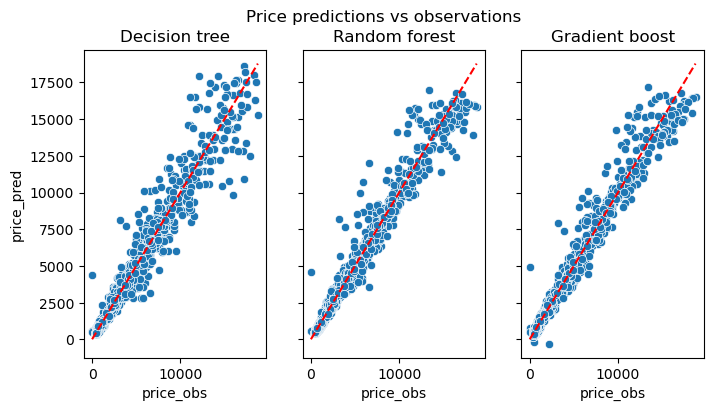

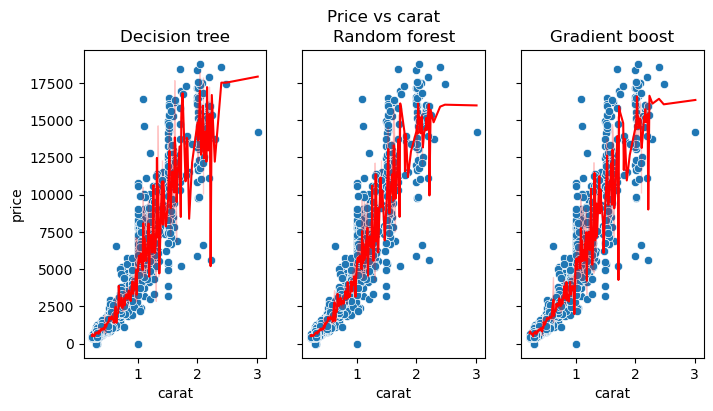

In [21]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings('ignore') # Workaround for a warning bug in seaborn 0.12.2

# Plot price predictions vs observations
x_line = np.linspace(0, max(y_test))
y_line = x_line
fig, axes = plt.subplots(1, 3, figsize=(8,4), sharey=True)
fig.suptitle('Price predictions vs observations')
for i, name in enumerate(regressors.keys()):
    sns.scatterplot(x=y_test, y=predictions[i], ax=axes[i])
    sns.lineplot(x=x_line, y=y_line, color='r', linestyle='--', ax=axes[i])
    if i==0:
        axes[i].set(xlabel='price_obs', ylabel='price_pred', title=name)
    else:
        axes[i].set(xlabel='price_obs', title=name)

# Plot price vs carat
fig, axes = plt.subplots(1, 3, figsize=(8,4), sharey=True)
fig.suptitle('Price vs carat')
for i, name in enumerate(regressors.keys()):
    sns.scatterplot(x=X_test['carat'], y=y_test, ax=axes[i])
    sns.lineplot(x=X_test['carat'], y=predictions[i], color='r', ax=axes[i])
    axes[i].set(title=name)

warnings.resetwarnings()

In the *price* predictions vs observations plots the ordinary decision tree shows more dispersion with respect to the *y=x* line than the other two regressors. This indicates an inferior prediction performance of the ordinary decision tree. This behavior is also reflected in the *price* vs *carat* plot, where the predictions of the ordinary decision tree are noisier. Comparing the random forest with the gradient boosted ensemble, the plots are very similar, maybe slightly better for the former regressor.

Now, I'll compare the three regressors by means of a five-fold cross validation, using the coefficient of determination (*r*-squared) as the score.

In [22]:
from sklearn.model_selection import cross_validate, KFold

# Perform five-fold cross validation for the three regressors
cv = KFold(n_splits=5, shuffle=True, random_state=1)
results = []
for name, regressor in regressors.items():
    cross_val = cross_validate(
        regressor, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2',
        return_train_score=True)
    result = {'regressor': name,
              'mean_train_score': cross_val['train_score'].mean(),
              'mean_test_score': cross_val['test_score'].mean(),
              'std_test_score': cross_val['test_score'].std(),
              'mean_fit_time': cross_val['fit_time'].mean(),
    }
    results.append(result)

# Print the results
pd.DataFrame(results)

regressor  mean_train_score  mean_test_score  std_test_score  \
0   Decision tree          0.990915         0.937179        0.010733   
1   Random forest          0.987668         0.961882        0.006820   
2  Gradient boost          0.975241         0.962143        0.007443   

   mean_fit_time  
0       1.073324  
1       2.231443  
2       1.405688

The ordinary decision tree has a pretty decent test score, much more if we consider it is the fastest. The random forest and the gradient boosted ensemble have similar test scores, better than the ordinary decision tree. Even more, they show less overfitting (this is one of the advantages of ensemble algorithms, so actually it is not surprising). Hence, despite it being much faster, I will dismiss the ordinary decision tree based on its worst test score and overfitting. And, between the random forest and the gradient boosted ensemble, I will choose the latter because it is faster and it seems to overfit a bit less.

### 3.2. Hyperparameter tuning

Now, for the gradient boosted ensemble I will do a (not very exhaustive) hyperparameter tuning to try improving its performance. I will perform a grid search for the number of regression trees in the ensemble (*n_estimators*) and the learning rate. These are two of the most important parameters for gradient boosting. They have an influence in speed, scoring, and overfitting.

In [23]:
from sklearn.model_selection import GridSearchCV

# Set the grid values
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.1, 1.0],
}

# Perform the search
cv = KFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(
        estimator=gb,
        param_grid=param_grid,
        return_train_score=True,
        cv=cv,
).fit(X_train, y_train)

# Print selected results, sorted by test score
pd.DataFrame(grid_search.cv_results_)[[
    'rank_test_score',
    'param_regressor__learning_rate',
    'param_regressor__n_estimators',
    'mean_train_score',
    'mean_test_score',
    'std_test_score',
    'mean_fit_time',
]].sort_values('rank_test_score')

rank_test_score param_regressor__learning_rate  \
5                1                            0.1   
4                2                            0.1   
3                3                            0.1   
6                4                            1.0   
7                5                            1.0   
8                6                            1.0   
2                7                           0.01   
1                8                           0.01   
0                9                           0.01   

  param_regressor__n_estimators  mean_train_score  mean_test_score  \
5                           200          0.980200         0.963781   
4                           100          0.975247         0.961857   
3                            50          0.963959         0.952830   
6                            50          0.981372         0.945447   
7                           100          0.985307         0.942117   
8                           200          0.987909         0.940476   
2                           200          0.913141         0.906482   
1                           100          0.781521         0.777315   
0                            50          0.564708         0.562450   

   std_test_score  mean_fit_time  
5        0.007421       1.300814  
4        0.007378       1.073951  
3        0.007388       0.966633  
6        0.013868       0.973117  
7        0.014400       1.081753  
8        0.016795       1.303392  
2        0.008862       1.297531  
1        0.011909       1.087900  
0        0.011415       1.027260

Among the tested values, except for *learning_rate*=1.0, the highest the *n_estimators* values, the better. A learning rate of 0.1 gives the best performance. For this value, increasing *n_estimators* from 100 to 200 offers a negligible improvement in and the test score, and raises the fitting time a 25%. From *n_estimators*=50 to *n_estimators*=100 there is also a ~1% improvement in the test score, with a ~15% increase in fitting time.

### 3.3. Model fitting and evaluation

Taking into account the results from the hyperparameter tuning, I will fit a `scikit-learn` `GradientBoostingRegressor` with *n_estimators*=100 and *learning_rate*=0.1 (both of them actually are the default values), which I think gives a good balance between score and speed. I will also perform a five-fold cross validation to evaluate the performance.

In [24]:
# Initialize the pipeline (now, "the" model)
model = Pipeline([
    ('encoder', encoder),
    ('cleaner', cleaner),
    ('dropper', dropper),
    ('regressor', GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
    )),
])

# Fit the model
model.fit(X_train, y_train)

# Perform five-fold cross validation for the model
cv = KFold(n_splits=5, shuffle=True, random_state=1)
model_cross_val = cross_validate(model, X_train, y_train, cv=cv, n_jobs=-1,
                                 scoring='r2', return_train_score=True)
model_result = {
    'mean_train_score': [model_cross_val['train_score'].mean()],
    'mean_test_score': model_cross_val['test_score'].mean(),
    'std_test_score': model_cross_val['test_score'].std(),
}

# Print cross validation result
pd.DataFrame(model_result)

mean_train_score  mean_test_score  std_test_score
0          0.975249         0.961851        0.007456

Now, I'll finish the model evaluation by plotting comparisons between observations and model predictions, and also the residuals of the model.

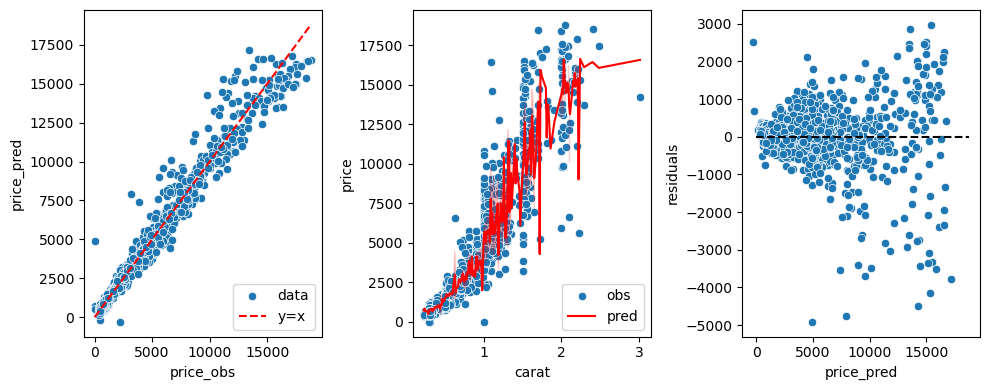

In [25]:
warnings.filterwarnings('ignore') # Workaround for a warning bug in seaborn 0.12.2

# Plot model results and residuals
x_line = np.linspace(0, max(y_test))
y_line = x_line
model_preds = model.predict(X_test)
fig, axes = plt.subplots(1, 3, figsize=(10,4))
# First subplot: price predictions vs observations
sns.scatterplot(x=y_test, y=model_preds, label='data', ax=axes[0])
sns.lineplot(x=x_line, y=y_line, color='r', linestyle='--', label='y=x', ax=axes[0])
axes[0].set(xlabel='price_obs', ylabel='price_pred')
axes[0].legend(loc='lower right')
# Second subplot: price vs carat
sns.scatterplot(x=X_test['carat'], y=y_test, label='obs', ax=axes[1])
sns.lineplot(x=X_test['carat'], y=model_preds, color='r', label='pred', ax=axes[1])
# Third subplot: residuals
sns.scatterplot(x=model_preds, y=y_test-model_preds, ax=axes[2])
sns.lineplot(x=x_line, y=np.zeros(x_line.shape[0]), color='k', linestyle='--',
             ax=axes[2])
axes[2].set(xlabel='price_pred', ylabel='residuals')
plt.tight_layout()

warnings.resetwarnings()

I actually already shown and inspected the first two plots when selecting between the ordinary decision tree, the random forest and the gradient boosted ensemble (because finally I used the default parameters for the latter). What I see from the first subplot is that the model does a pretty good job predicting the observations in the test set. But, the predictive performance of the model starts to deteriorate as the *price* increases. This is further confirmed in the other two subplots, especially when looking at the residuals. In the central subplot it is evident that the predictions are noisy and affected by the possible outliers at *carat*>2.5. The noise in the predictions is a signal of overfitting, possibly due to using a more complex model than actually needed.

### 3.4. Feature importance

To give a closure to the model development, I will take a look to the (impurity-based) feature importance already implemented in the class `GradientBoostingRegressor` (`scikit-learn` also offers a function to compute the *permutation importance*, which tends to inflate less the importance of high-cardinality features, but for the sake of brevity I won't use it).

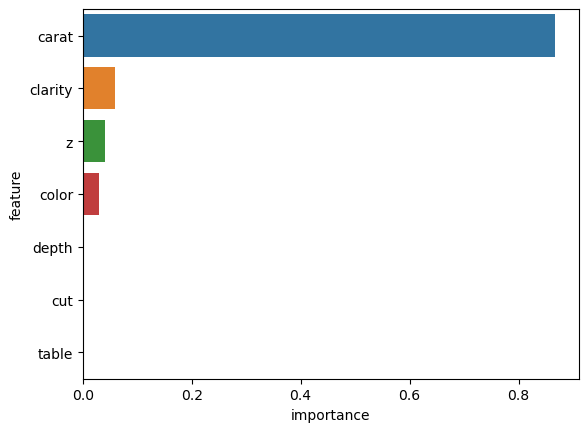

In [26]:
# Plot mean decrease in impurity (MDI)

warnings.filterwarnings('ignore') # Workaround for a warning bug in seaborn 0.12.2

feat_names = model.named_steps['dropper'].get_feature_names_out()
feat_names = [str.removeprefix(name, 'remainder__') for name in feat_names]
feat_importance_values = model.named_steps['regressor'].feature_importances_

feat_importance_df = pd.DataFrame({'feature': feat_names,
                                   'importance': feat_importance_values})
feat_importance_df.sort_values('importance', inplace=True, ascending=False)
sns.barplot(data=feat_importance_df, x='importance', y='feature')

warnings.resetwarnings()

As suspected from the EDA, the feature *carat* is the most important by far. During the EDA, although it was highly correlated to *carat*, I chose to keep the feature *z* in the dataset because the interaction between these two features was non-linear. I wanted to get to this step to confirm if *z* was not important. The same for the other, not-correlated-to-*carat*, features. In a larger dataset with a higher number of features, perhaps I would have dropped more features based on the correlation analysis for saving computer resources. Or I would have done the same work than I did here with a subsample of the dataset.

## 4. Final remarks

From the evaluation of the model and the feature importance, at least, it would be interesting to check the performance of a model using only *carat* as predictive feature. I think that a simple polynomial or spline model (both easy to apply in `scikit-learn`) could do the job. Maybe this time the all-mighty machine learning tools were too much. But, I also think that this is a good exercise to showcase some key features of modeling and some of my skills. I hope you enjoyed the notebook. Thanks.